In [1]:
## Part 1: Import Libraries and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)


In [2]:
# Parameter Grids & Base Classifiers

param_grid_dt = {
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10]
}
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

# Base classifiers
dt_clf  = DecisionTreeClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
lr_clf  = LogisticRegression(random_state=42)

# List of (classifier, param_grid, name)
classifiers_to_tune = [
    (dt_clf,  param_grid_dt, 'Decision Tree'),
    (knn_clf, param_grid_knn, 'kNN'),
    (lr_clf,  param_grid_lr, 'Logistic Regression'),
]


In [3]:

# Dataset Loader: HR Attrition

def load_hr_attrition_dataset():
    df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

    y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
    X = df.drop(columns=['Attrition', 'EmployeeNumber'], errors='ignore')

    # Encode categorical features
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    return train_test_split(X.values, y.values, test_size=0.3, stratify=y, random_state=42)


In [4]:
#Manual Grid Search Implementation


from sklearn.base import clone

def run_manual_grid_search(X_train, y_train):
    print("Running Manual Grid Search...")
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for clf, param_grid, name in classifiers_to_tune:
        best_score = -np.inf
        best_estimator = None

        # try each parameter combination
        from itertools import product
        keys, values = zip(*param_grid.items())
        for combo in product(*values):
            params = dict(zip(keys, combo))
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('select', SelectKBest(score_func=f_classif, k='all')),
                ('classifier', clone(clf))
            ])
            pipe.set_params(**params)
            scores = []

            for train_idx, val_idx in cv.split(X_train, y_train):
                pipe.fit(X_train[train_idx], y_train[train_idx])
                y_prob = pipe.predict_proba(X_train[val_idx])[:, 1]
                scores.append(roc_auc_score(y_train[val_idx], y_prob))

            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_estimator = pipe

        results[name] = {"best_estimator": best_estimator, "best_score": best_score}
        print(f"{name} Best CV AUC: {best_score:.4f}")
    return results


In [5]:
# Built-in GridSearchCV


def run_builtin_grid_search(X_train, y_train):
    print("Running Built-in GridSearchCV...")
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for clf, param_grid, name in classifiers_to_tune:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('select', SelectKBest(score_func=f_classif)),
            ('classifier', clf)
        ])
        grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
        grid.fit(X_train, y_train)
        results[name] = {"best_estimator": grid.best_estimator_, "best_score": grid.best_score_}
        print(f"{name} Best CV AUC: {grid.best_score_:.4f}")
    return results


In [6]:
def evaluate_models(X_test, y_test, estimators, method_name):
    print(f"\nEvaluating {method_name} Models...")
    for name, model in estimators.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        print(f"\n{name}:")
        print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f" Precision: {precision_score(y_test, y_pred):.4f}")
        print(f" Recall: {recall_score(y_test, y_pred):.4f}")
        print(f" F1: {f1_score(y_test, y_pred):.4f}")
        print(f" ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    # Voting classifier
    voting = VotingClassifier(estimators=[(n, m) for n, m in estimators.items()], voting='soft')
    voting.fit(X_test, y_test)
    y_pred = voting.predict(X_test)
    y_proba = voting.predict_proba(X_test)[:,1]

    print("\nVoting Classifier:")
    print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f" Precision: {precision_score(y_test, y_pred):.4f}")
    print(f" Recall: {recall_score(y_test, y_pred):.4f}")
    print(f" F1: {f1_score(y_test, y_pred):.4f}")
    print(f" ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
    plt.show()


Running Manual Grid Search...


c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24

Decision Tree Best CV AUC: 0.6930


c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24

kNN Best CV AUC: 0.7191
Logistic Regression Best CV AUC: 0.8154

Evaluating Manual Models...

Decision Tree:
 Accuracy: 0.8277
 Precision: 0.4324
 Recall: 0.2254
 F1: 0.2963
 ROC AUC: 0.6939

kNN:
 Accuracy: 0.8413
 Precision: 0.5714
 Recall: 0.0563
 F1: 0.1026
 ROC AUC: 0.6773

Logistic Regression:
 Accuracy: 0.8662
 Precision: 0.7308
 Recall: 0.2676
 F1: 0.3918
 ROC AUC: 0.8057


c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24


Voting Classifier:
 Accuracy: 0.9456
 Precision: 1.0000
 Recall: 0.6620
 F1: 0.7966
 ROC AUC: 0.9997


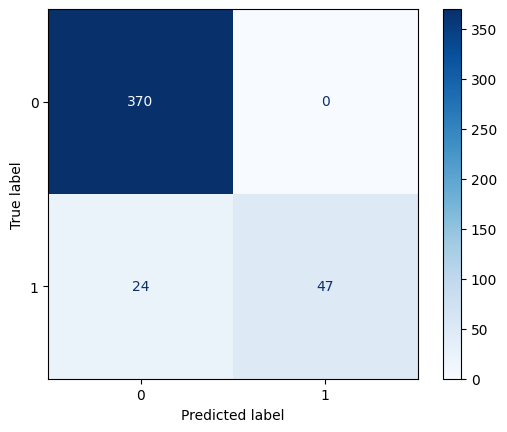

Running Built-in GridSearchCV...


c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\Musharraf\anaconda3\envs\ml-env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7 19 24

Decision Tree Best CV AUC: 0.7164
kNN Best CV AUC: 0.7121
Logistic Regression Best CV AUC: 0.7532

Evaluating Built-in Models...

Decision Tree:
 Accuracy: 0.8322
 Precision: 0.4571
 Recall: 0.2254
 F1: 0.3019
 ROC AUC: 0.7331

kNN:
 Accuracy: 0.8390
 Precision: 0.5000
 Recall: 0.2254
 F1: 0.3107
 ROC AUC: 0.7285

Logistic Regression:
 Accuracy: 0.8458
 Precision: 1.0000
 Recall: 0.0423
 F1: 0.0811
 ROC AUC: 0.7545

Voting Classifier:
 Accuracy: 0.8617
 Precision: 0.9167
 Recall: 0.1549
 F1: 0.2651
 ROC AUC: 0.8828


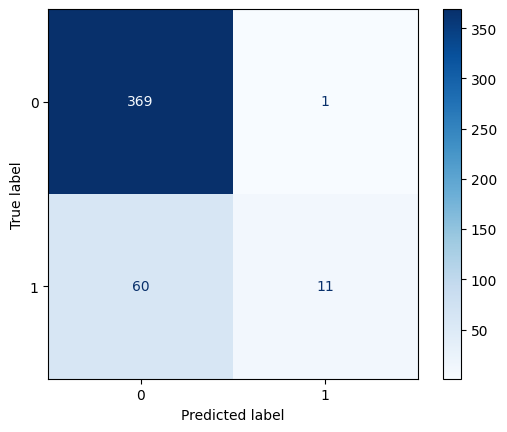

In [7]:
X_train, X_test, y_train, y_test = load_hr_attrition_dataset()

# Manual
manual = run_manual_grid_search(X_train, y_train)
evaluate_models(X_test, y_test, {n:r["best_estimator"] for n,r in manual.items()}, "Manual")

# Built-in
builtin = run_builtin_grid_search(X_train, y_train)
evaluate_models(X_test, y_test, {n:r["best_estimator"] for n,r in builtin.items()}, "Built-in")
